In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -r requirements.txt

## 1. Load data

In [2]:
import random
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from torchvision.utils import make_grid
import torch as torch

SEED = 42
random.seed(0)
np.random.seed(0)
torch.manual_seed(SEED)

In [ ]:
BASEDIR = "./archive"

DIR_TRAIN = f"{BASEDIR}/train/"
DIR_VALID = f"{BASEDIR}/valid/"
DIR_TEST = f"{BASEDIR}/test/"

In [3]:
# Remove duplicated space
!mv f'{DIR_VALID}/BLACK & YELLOW  BROADBILL' f'{DIR_VALID}/BLACK & YELLOW BROADBILL'

"mv" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"YELLOW" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
"YELLOW" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [4]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ", len(classes))

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(os.path.join(DIR_TRAIN, _class)))
    valid_count += len(os.listdir(os.path.join(DIR_VALID, _class)))
    test_count += len(os.listdir(os.path.join(DIR_TEST, _class)))

print("Total train images: ", train_count)
print("Total valid images: ", valid_count)
print("Total test images: ", test_count)

Total Classes:  400
Total train images:  58388
Total valid images:  2000
Total test images:  2000


In [5]:
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)

    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)

    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [6]:
class BirdDataset(Dataset):
    def __init__(self, image_paths, class_to_index, transforms=None):
        super().__init__()
        self.image_paths = image_paths
        self.class_to_int = class_to_index
        self.transforms = transforms

    def __getitem__(self, index):
        image_path = self.image_paths[index]

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)

        label = image_path.split("/")[-2]
        label = self.class_to_int[label]

        return image_path, image, label

    def __len__(self):
        return len(self.image_paths)

In [7]:
from torchvision import transforms


def get_train_transform(image_size, pretrained):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        get_normalize_transform(pretrained)
    ])
    return transform

def get_validation_transform(image_size, pretrained):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        get_normalize_transform(pretrained)
    ])
    return transform


def get_normalize_transform(pretrained):
    # Use ImageNet values
    transform = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    return transform

In [8]:
train_dataset = BirdDataset(train_imgs, class_to_int, transforms=get_train_transform(224, True))
valid_dataset = BirdDataset(valid_imgs, class_to_int, transforms=get_validation_transform(224, True))
test_dataset = BirdDataset(test_imgs, class_to_int, transforms=get_validation_transform(224, True))

train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

BATCH_SIZE = 16
NUM_WORKERS = 1

train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_random_sampler,
)

valid_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    sampler=valid_random_sampler,
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    sampler=test_random_sampler,
)

Visualize one training batch (without normalization transform).

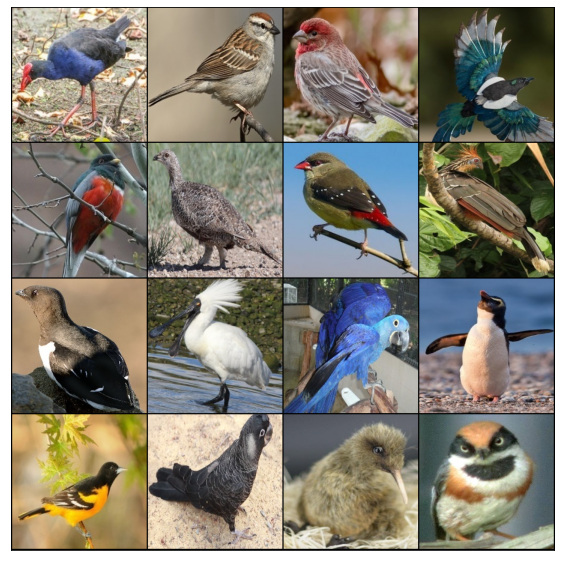

In [9]:
check_dataset = BirdDataset(
    train_imgs,
    class_to_int,
    transforms=transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]))
check_random_sampler = RandomSampler(check_dataset)
check_data_loader = DataLoader(
    dataset=check_dataset,
    batch_size=16,
    sampler=check_random_sampler,
)

for _, images, labels in check_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1, 2, 0))
    break

## 2. Train model

### 2.1. Сhoice of neural network architecture

We will choose EfficientNet architecture because:
1. It's among the top models by [image classification rating](https://paperswithcode.com/sota/image-classification-on-imagenet)
2. It has PyTorch implementations which are easy to adapt for fine-tuning.

We will use implementation from torchvision library.
Let's start with EfficientNet-B0 variant.

### 2.2. Architecture recap

EfficientNet is a family of architectures build with reasonable size in mind. It starts with baseline B0 architecture, growing to B7 by using scaling in 3 dimensions: width (number of channels), depth (number of layers) and image resolution.
EfficientNet achieves state-of-the-art results on image classification task by using fewer parameters than other architectures:
![plot](efficientnet.png "EfficientNet accuracy and size")
![plot](efficientnet.png "EfficientNet accuracy and size")

Compound scaling can be described as follows:
1. Using baseline model (B0), we search for coefficients alpha, beta and gamma, that determine scaling proportions of depth, width and resolution (d, w, r).
2. Using coefficient for computational power (FLOPS) increase, we find new d, w, r that depend on alpha, beta, gamma.

### 2.3. Implementation

In [10]:
import torchvision.models as models
import torch.nn as nn


def build_model(pretrained=True, fine_tune=True, num_classes=10):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
            
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [11]:
import torch


def save_model(epochs, model, optimizer, criterion, path_to_checkpoint):
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, path_to_checkpoint)

In [12]:
from IPython.core.display_functions import clear_output
import pandas as pd

def exponential_moving_avg(data, span):
    return pd.DataFrame({'data': data})['data'].ewm(span=span).mean().values

def save_plots(train_acc, valid_acc, train_loss, valid_loss, is_pretrained, scatter_alpha = 0.2):
    clear_output(True)

    figure, (axes_loss, axes_accuracy) = plt.subplots(1, 2, figsize=[20, 10])

    axes_loss.set_title('Loss')
    axes_loss.set_xlabel('Epoch number')
    axes_loss.grid(False)
    axes_loss.scatter(np.arange(len(train_loss)), train_loss, alpha=scatter_alpha, label='train loss')
    axes_loss.plot(exponential_moving_avg(train_loss, span=10))
    axes_loss.scatter(np.arange(len(valid_loss)), valid_loss, alpha=scatter_alpha, label='validation loss')
    axes_loss.plot(exponential_moving_avg(valid_loss, span=10))
    axes_loss.legend()

    axes_accuracy.set_title('Accuracy')
    axes_accuracy.set_xlabel('Epoch number')
    axes_accuracy.grid(False)
    axes_accuracy.scatter(np.arange(len(train_acc)), train_acc, alpha=scatter_alpha, label='train accuracy')
    axes_accuracy.plot(exponential_moving_avg(train_acc, span=10))
    axes_accuracy.scatter(np.arange(len(valid_acc)), valid_acc, alpha=scatter_alpha, label='validation accuracy')
    axes_accuracy.plot(exponential_moving_avg(valid_acc, span=10))
    axes_accuracy.legend()

    plt.show()
    plt.savefig(f"outputs/plots_{'fine_tuned' if is_pretrained else 'from_scratch'}.png")

In [13]:
from tqdm.auto import tqdm

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_accuracy = 0
    for i, data in tqdm(enumerate(loader), total=len(loader)):
        _, image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_accuracy += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / len(loader)
    epoch_acc = 100. * (train_running_accuracy / len(loader.dataset))
    return epoch_loss, epoch_acc

In [14]:
def validate_epoch(model, loader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_accuracy = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            _, image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_accuracy += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / len(loader)
    epoch_acc = 100. * (valid_running_accuracy / len(loader.dataset))
    return epoch_loss, epoch_acc

In [15]:
from torch import optim


def train(model, lr, epochs, path_to_checkpoint, is_pretrained):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch + 1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train_epoch(model, train_data_loader, optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate_epoch(model, valid_data_loader, criterion)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-' * 50)

        save_plots(train_acc, valid_acc, train_loss, valid_loss, is_pretrained)

    save_model(epochs, model, optimizer, criterion, path_to_checkpoint)

Visualize model structure.

In [16]:
print(f"Model structure: {build_model(pretrained=False, fine_tune=False, num_classes=len(classes))}\n")

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
Model structure: EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)

We can see groups of MBConv layers, each of them wraps several convolution blocks and squeeze-and-excitation block. Our classification layer was appended to the end, as expected.

Let's train model from scratch.

In [20]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.cuda.memory_summary(device=None, abbreviated=False)

cuda


In [18]:
config_train_from_scratch = {
    "lr": 0.001,
    "epochs": 5,
    "path_to_checkpoint": "outputs/model_from_scratch.pth",
    "is_pretrained": False
}

model = build_model(
    pretrained=False,
    fine_tune=True,
    num_classes=len(classes)
).to(device)

train(model, **config_train_from_scratch)

[INFO]: Not loading pre-trained weights
[INFO]: Fine-tuning all layers...
[INFO]: Epoch 1 of 5


  0%|          | 0/1825 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.59 GiB already allocated; 0 bytes free; 2.70 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Let’s train model from pretrained checkpoint (trained on ImageNet dataset). Decrease learning rate.

<Figure size 432x288 with 0 Axes>

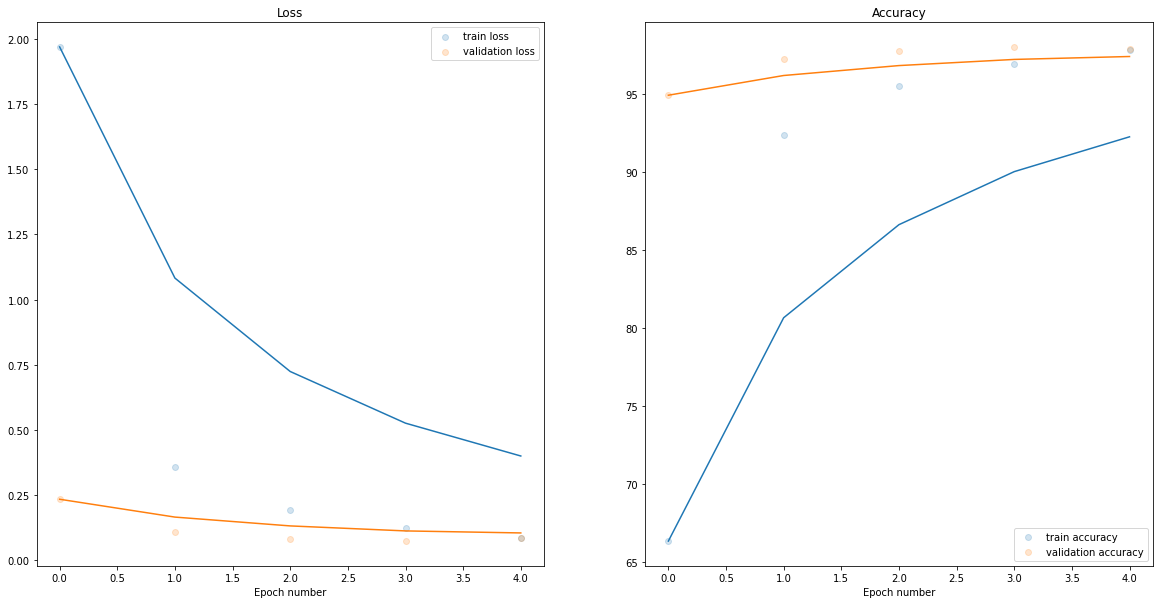

<Figure size 432x288 with 0 Axes>

In [77]:
config_fine_tune = {
    "lr": 0.0001,
    "epochs": 5,
    "path_to_checkpoint": "outputs/model_fine_tuned.pth",
    "is_pretrained": True
}

model = build_model(
    pretrained=True,
    fine_tune=True,
    num_classes=len(classes)
).to(device)

train(model, **config_fine_tune)

## 3. Evaluate model

Let's evaluate fine-tuned model, that showed the best accuracy during training.

In [78]:
import torch
import cv2
import numpy as np
from torchvision import transforms

device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = build_model(pretrained=False, fine_tune=False, num_classes=len(classes)).to(device)
checkpoint = torch.load('outputs/model_fine_tuned.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...


<All keys matched successfully>

In [79]:
from sklearn.metrics import classification_report
import torch.nn.functional as F


def get_accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()


def evaluate(model, device, loader, classes):
    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader)):
            _, images, y_true_for_batch = data
            images = images.to(device)
            outputs = model(images)
            _, y_pred_for_batch = torch.max(outputs.data, 1)

            y_pred.append(y_pred_for_batch.cpu())
            y_true.append(y_true_for_batch)

    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    print('Accuracy: ', get_accuracy(y_pred, y_true))
    print('Classification report:')
    print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

In [80]:
evaluate(model, device, test_data_loader, classes)

  0%|          | 0/125 [00:00<?, ?it/s]

Accuracy:  0.9875
Classification report:
                             precision    recall  f1-score   support

            ABBOTTS BABBLER       1.00      1.00      1.00         5
              ABBOTTS BOOBY       1.00      1.00      1.00         5
 ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
      AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
     AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
          AFRICAN FIREFINCH       1.00      1.00      1.00         5
     AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
                  ALBATROSS       1.00      1.00      1.00         5
             ALBERTS TOWHEE       1.00      1.00      1.00         5
       ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
              ALPINE CHOUGH       1.00      1.00      1.00         5
      ALTAMIRA YELLOWTHROAT       1.00      0.80      0.89         5
            AMERICAN AVOCET       1.00      1.00      1.00   

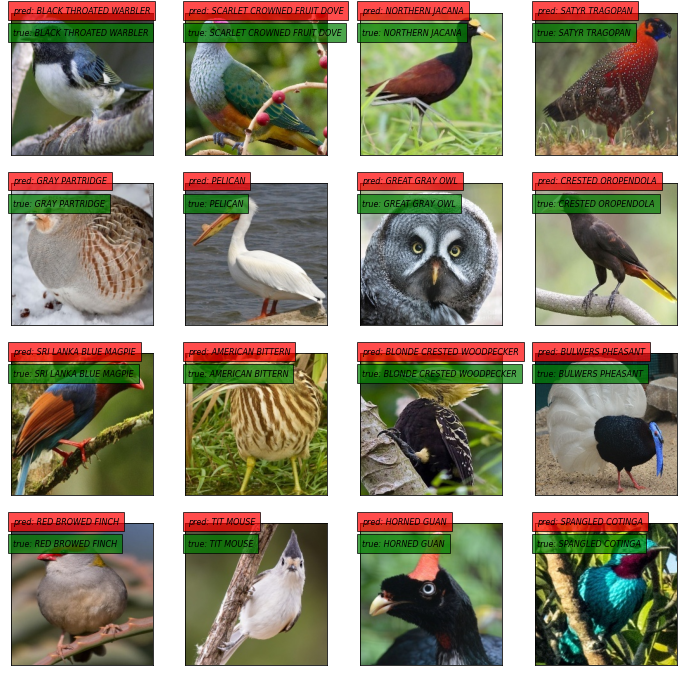

In [81]:
for image_paths, images, labels in test_data_loader:
    images = images.to(device)
    outputs = model(images)
    _, y_pred_for_batch = torch.max(outputs.data, 1)

    original_images = [cv2.imread(image_path) for image_path in image_paths]
    original_images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in original_images]

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(original_images, axes)):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(3, 0, f'pred: {classes[y_pred_for_batch[i]]}', style='italic', fontsize=8, bbox={'facecolor': 'red', 'alpha': 0.7, 'pad': 5})
        ax.text(3, 35, f'true: {classes[labels[i]]}', style='italic', fontsize=8, bbox={'facecolor': 'green', 'alpha': 0.7, 'pad': 5})
        ax.imshow(img)
    plt.show()
    break

## 4. Model improvements

Let's try to train model with different augmentations. We will use augmentations in our transformations pipeline.

In [ ]:
from torchvision import transforms


def get_train_transform(image_size, pretrained):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        get_normalize_transform(pretrained)
    ])
    return transform

def get_validation_transform(image_size, pretrained):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        get_normalize_transform(pretrained)
    ])
    return transform


def get_normalize_transform(pretrained):
    # Use ImageNet values
    transform = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    return transform

## 5. Conclusions